In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing'

In [4]:
rootfolder = '/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing/Assignments'

Useful function for plot a 2D dictionary

In [5]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [6]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x_OMP = np.zeros(N)
  # Support set
  omega = []
  # residual
  r = s

  # STOPPING CRITERIA
  while np.count_nonzero(x_OMP) < L and np.linalg.norm(r) > tau:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:,j]
        zj = ((r.T @ dj) / np.linalg.norm(dj))**2
        e[j] = np.linalg.norm(r)**2 - zj

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    D_omega = D[:, omega]
    D_omega_T_D_omega = np.dot(D_omega.T, D_omega)
    x_OMP[omega] = np.dot(np.linalg.inv(D_omega_T_D_omega), np.dot(D_omega.T, s))

    # update the residual
    r = s - np.dot(D, x_OMP)

  return x_OMP

Useful function for computing the PSNR

In [8]:
def compute_psnr(Y_true, Y_pred):
  mse = np.square(np.subtract(Y_true,Y_pred)).mean()
  #max_signal = np.max(Y_true)
  max_signal = 1
  return 10* np.log10(max_signal**2 / mse)

Load the image and rescale it in $[0,1]$

In [9]:
img = imread(f'{rootfolder}/data/peppers256.png') / 255
# img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [10]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Percentage of removed pixel

In [11]:
perc_of_removed_pixels = 0.25

Arbitrarily remove pixels setting them to zero

In [12]:
# create a vector with all the indexes of the image
idx = np.arange(imsz[0]*imsz[1])

# shuffle it and take the target percentage of indexes
idx = np.random.permutation(idx)
idx = idx[:int(perc_of_removed_pixels*imsz[0]*imsz[1])]

# the mask is 0 for the chosen idx, 1 elsewhere
msk = np.ones(imsz)
msk.ravel()[idx] = 0
# apply the mask: set to 0 some elements in the noisy image
noisy_img = noisy_img * msk


Compute the psnr of the noisy input

In [13]:
psnr_noisy = compute_psnr(img, noisy_img)

Text(0.5, 1.0, 'Dead pixels')

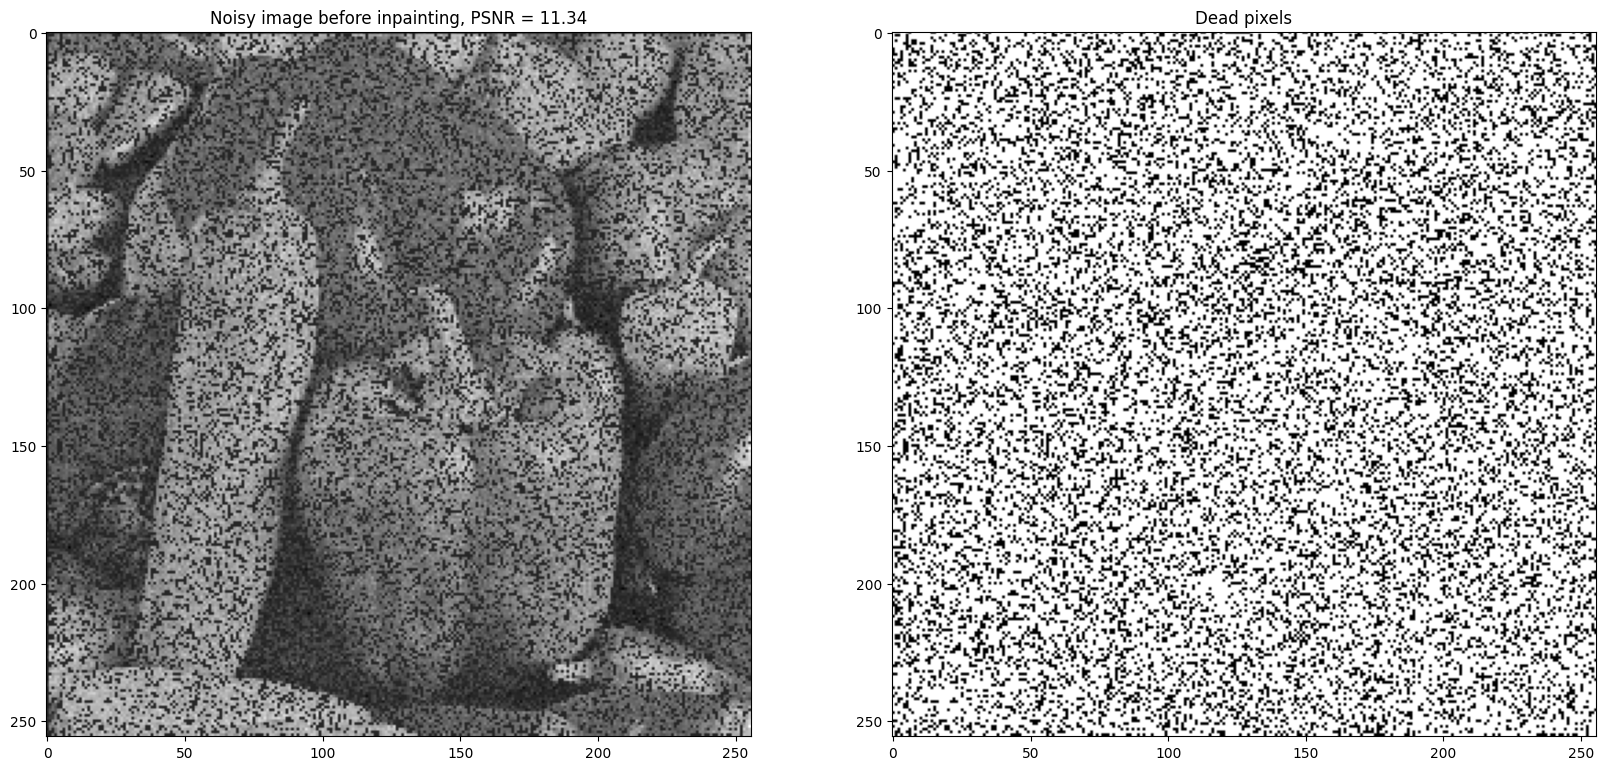

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(noisy_img, cmap='gray')
ax[0].set_title(f'Noisy image before inpainting, PSNR = {psnr_noisy:.2f}')

ax[1].imshow(msk, cmap='gray')
ax[1].set_title(f'Dead pixels')


Load and display the dictionary learned from patches

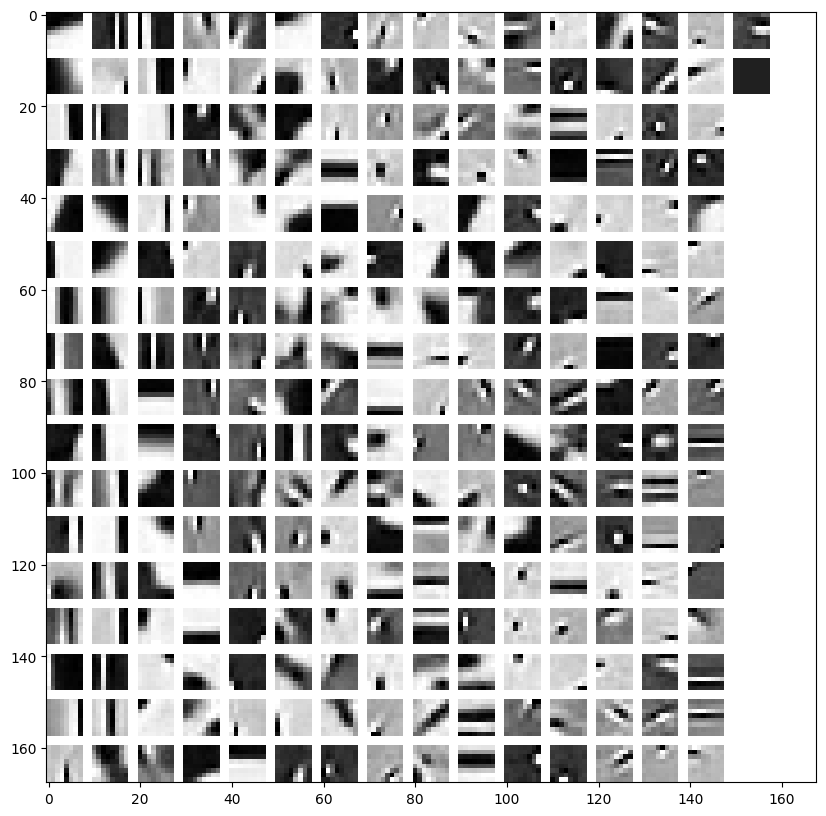

In [15]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# add a constant atom to D, KSVD was trained over patches with zero mean - and normalize it
# UPDATE D
costant_atom = np.ones((D.shape[0], 1))
D = np.hstack((D, costant_atom))

# Normalize the dictionary
D[:, -1] = D[:, -1]/np.linalg.norm(D[:, -1], 2)

# display the dictionary
D_img = get_dictionary_img(D)

plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

Inpainting
----------


In [16]:
# SET stopping criteria of OMP
# orthogonal matching pursuit uses sparsity and errors as stopping criteria
L = M / 2

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# define the step (=p for non overlapping paches)
STEP = 1 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [17]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].reshape(-1)

        # patch extracted from the mask
        m = msk[i:i+p, j:j+p].reshape(-1)

        # design the projection operator over the current patch
        proj = np.diag(m)

        # tau should be proportional to the number of pixels remaining in the patch
        tau = 1.156 * np.sqrt(np.count_nonzero(s)) * sigma_noise

        # sparse coding w.r.t. PD the inpainted dictionary using L and tau as stopping criteria
        P_D = np.dot(proj, D)
        x_OMP = OMP(s, P_D, L, tau)

        # reconstruction: synthesis w.r.t. D the dictionary yielding sparse representation
        s_hat = np.dot(D, x_OMP)

        # use uniform weights for aggregation
        w = 1

        # put the denoised patch into the estimated image using uniform weights
        # UPDATE img_hat
        img_hat[i:i+p, j:j+p] = img_hat[i:i+p, j:j+p] + w * s_hat.reshape((p,p))

        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        weights[i:i+p, j:j+p] = weights[i:i+p, j:j+p] + w


Normalize the estimated image with the computed weights

In [18]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

In [19]:
psnr_hat = compute_psnr(img, img_hat)

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 29.87')

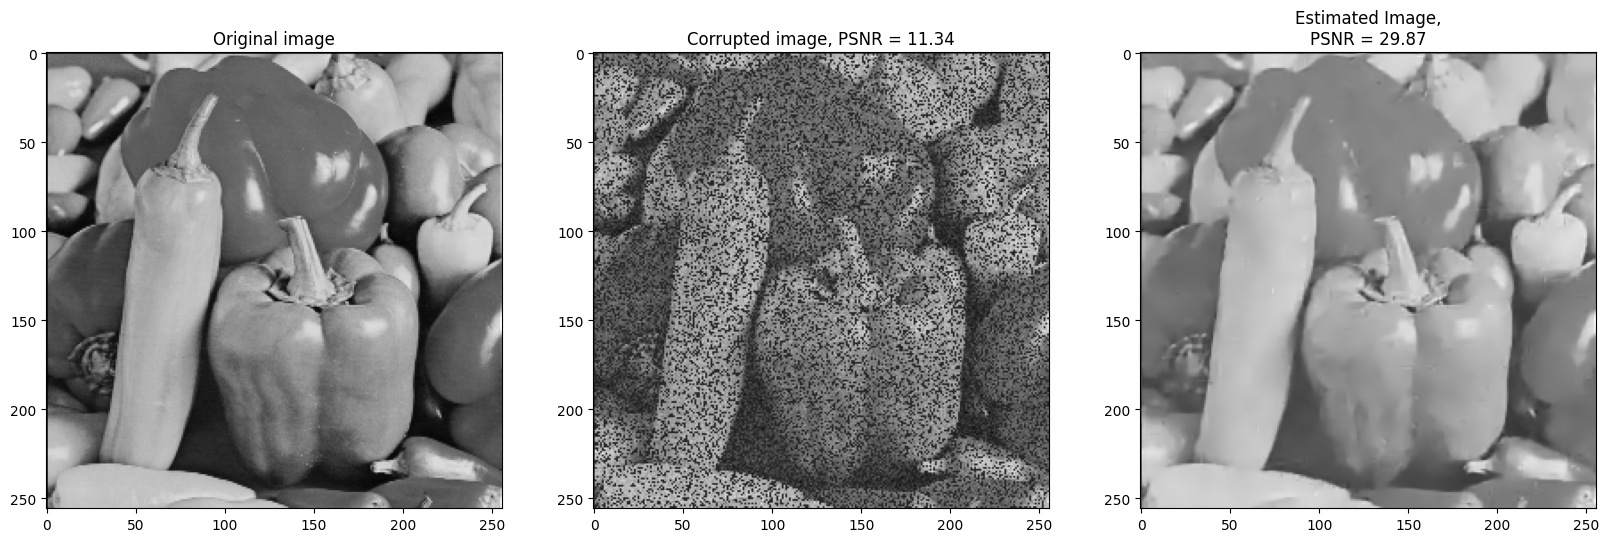

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(img, cmap='gray')
ax[0].set_title(f'Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Corrupted image, PSNR = {psnr_noisy:.2f}')

ax[2].imshow(img_hat, cmap='gray')
ax[2].set_title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
